In [1]:
using Images,CuArrays,Flux
using Flux:@treelike, Tracker
using Base.Iterators: partition
using Random
using Statistics
using BSON:@save, @load
using Flux:testmode!
using CUDAdrv

┌ Warning: Flux is only supported with CuArrays v0.9.
│ Try running `] pin CuArrays@0.9`.
└ @ Flux.CUDA /home/shreyas/.julia/packages/Flux/WSB7k/src/cuda/cuda.jl:12


In [13]:
path = "../data/train/"
function load_image(filename)
    img = load(filename)
    img = Float64.(channelview(img))
end

function load_dataset(path,imsize)
    imgsA = []
    imgsB = []
    for r in readdir(path)
        img_path = string(path,r)
        push!(imgsA,load_image(img_path)[:,:,1:256])
        push!(imgsB,load_image(img_path)[:,:,257:end])
    end
    return reshape(cat(imgsA...,dims=4),imsize,imsize,3,length(imgsA)),reshape(cat(imgsB...,dims=4),imsize,imsize,3,length(imgsB))
end

load_dataset (generic function with 1 method)

In [14]:
train_A,train_B = load_dataset("../data/train/",256)

([0.803922 0.631373 … 0.423529 0.603922; 0.811765 0.647059 … 0.415686 0.615686; … ; 0.647059 0.0 … 0.0117647 0.745098; 0.627451 0.0 … 0.00784314 0.858824]

[0.815686 0.32549 … 0.572549 0.772549; 0.745098 0.313725 … 0.545098 0.705882; … ; 0.317647 0.0156863 … 0.705882 0.439216; 0.341176 0.0117647 … 0.807843 0.47451]

[0.462745 0.556863 … 0.137255 0.0117647; 0.447059 0.529412 … 0.0862745 0.0117647; … ; 0.027451 0.592157 … 0.00392157 0.0; 0.0235294 0.686275 … 0.00392157 0.0]

[0.623529 0.294118 … 0.254902 0.784314; 0.592157 0.211765 … 0.65098 0.752941; … ; 0.196078 0.6 … 0.203922 0.239216; 0.627451 0.286275 … 0.309804 0.607843]

[0.32549 0.207843 … 0.470588 0.309804; 0.231373 0.592157 … 0.4 0.219608; … ; 0.509804 0.207843 … 0.223529 0.607843; 0.286275 0.329412 … 0.603922 0.313725]

[0.239216 0.494118 … 0.411765 0.129412; 0.611765 0.423529 … 0.34902 0.129412; … ; 0.262745 0.223529 … 0.145098 0.129412; 0.2 0.643137 … 0.121569 0.0823529]

[0.686275 0.509804 … 0.623529 0.509804; 0.686275 0.50

In [15]:
size(train_B)

(256, 256, 3, 400)

In [2]:
include("utils.jl")
include("discriminator.jl")
include("generator.jl")

gen = UNet() |> gpu

function sampleA2B(X_A_test)
    """
    Samples new images in domain B
    X_A_test : N x C x H x W array - Test images in domain A
    """
    testmode!(gen)
    X_A_test = norm(X_A_test)
    X_B_generated = cpu(denorm(gen(X_A_test |> gpu)).data)
    testmode!(gen,false)
    imgs = []
    s = size(X_B_generated)
    for i in size(X_B_generated)[end]
       push!(imgs,colorview(RGB,reshape(X_B_generated[:,:,:,i],3,s[1],s[2])))
    end
    imgs
end

function test()
   # load test data
   dataA,_ = load_dataset("../data/train/",256)
   dataA = dataA[:,:,:,1] |> gpu
   dataA = reshape(dataA,256,256,3,1)
   out = sampleA2B(dataA)

   @load "../weights/gen.bson" gen
   for (i,img) in enumerate(out)
        save("../sample/A_$i.png",img)
   end
end

test (generic function with 1 method)

In [3]:
test()

A
A
A
A


(256, 256, 3, 400)


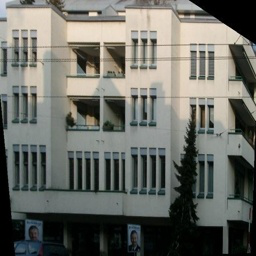

In [18]:
cpu_out = train_A[:,:,:,1]
cpu_out = reshape(cpu_out,3,256,256)
s = size(train_A)
println(s)
img = colorview(RGB,cpu_out)

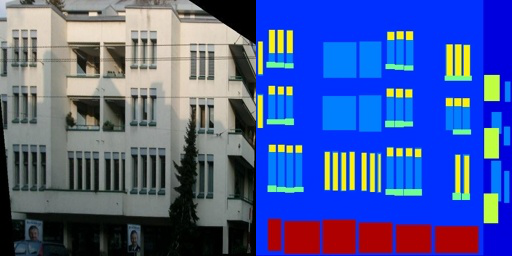

In [16]:
img = load("../data/train/1.jpg")

In [17]:
img_float = Float64.(channelview(img))
reshape_wala = reshape(img_float,256,512,3,1) |> gpu

256×512×3×1 CuArray{Float32,4}:
[:, :, 1, 1] =
 0.803922  0.631373    0.0         …  0.537255    0.572549  0.772549
 0.811765  0.647059    0.0            0.513726    0.545098  0.705882
 0.870588  0.631373    0.0            0.54902     0.521569  0.807843
 0.803922  0.635294    0.0            0.537255    0.623529  0.772549
 0.815686  0.65098     0.0            0.513726    0.603922  0.705882
 0.87451   0.631373    0.0         …  0.54902     0.580392  0.803922
 0.792157  0.639216    0.0            0.537255    0.584314  0.768627
 0.815686  0.635294    0.00784314     0.517647    0.572549  0.701961
 0.870588  0.631373    0.00784314     0.552941    0.552941  0.8     
 0.784314  0.65098     0.00784314     0.541176    0.560784  0.764706
 0.815686  0.635294    0.00784314  …  0.513726    0.556863  0.698039
 0.866667  0.623529    0.00784314     0.54902     0.541176  0.8     
 0.780392  0.643137    0.00784314     0.545098    0.533333  0.764706
 ⋮                                 ⋱              ⋮     

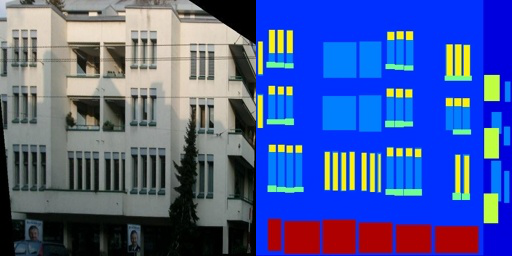

In [21]:
wapas_wala = cpu(reshape(reshape_wala,3,256,512))
colorview(RGB,reshape(wapas_wala,3,256,512))

In [24]:
img_float == train_A[1]

false

In [34]:
img_float[:,:,1:256] == reshape(train_A[:,:,:,1],3,256,256)

false

In [4]:
train_A

400-element Array{Any,1}:
 [0.803922 0.803922 … 0.0 0.0; 0.811765 0.815686 … 0.0 0.0; 0.870588 0.87451 … 0.0 0.0]

[0.815686 0.8 … 0.0 0.0; 0.823529 0.811765 … 0.0 0.0; 0.882353 0.870588 … 0.0 0.0]

[0.827451 0.815686 … 0.0 0.0; 0.835294 0.823529 … 0.0 0.0; 0.886275 0.87451 … 0.0 0.00784314]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.00392157 0.00784314; 0.0 0.0 … 0.00392157 0.00784314; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]                                                                                                                                                                                                                                                                                                      
 [0.623529 0.615686 … 0.0196078 0.0156863; 0.592157 0.572549 … 0.0 0.0; 0.501961 0.494118 … 0.00392157 0.0]

[0.619608 0.65098 … 0.0 0.0; 0.588235 0.607843 … 0.0117647 0.0235294; 0.498039 0.529412 … 0.00

In [26]:
imgs1 = cat(train_A...,dims=4)

3×256×256×400 Array{Float64,4}:
[:, :, 1, 1] =
 0.803922  0.803922  0.792157  0.784314  …  0.00392157  0.0  0.0  0.0
 0.811765  0.815686  0.815686  0.815686     0.00392157  0.0  0.0  0.0
 0.870588  0.87451   0.870588  0.866667     0.00392157  0.0  0.0  0.0

[:, :, 2, 1] =
 0.815686  0.8       0.784314  0.780392  …  0.00392157  0.0  0.0  0.0  0.0
 0.823529  0.811765  0.807843  0.811765     0.00392157  0.0  0.0  0.0  0.0
 0.882353  0.870588  0.862745  0.862745     0.00392157  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.827451  0.815686  0.807843  …  0.0  0.0  0.0  0.0  0.0  0.0       
 0.835294  0.823529  0.823529     0.0  0.0  0.0  0.0  0.0  0.0       
 0.886275  0.87451   0.870588     0.0  0.0  0.0  0.0  0.0  0.00784314

...

[:, :, 254, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0117647  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0117647  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0117647  0.0  0.0  0.0

[:, :, 255, 1] =
 0.0  0.0  0.

In [20]:
imgs2 = reshape(imgs1,3,256,256,400)

3×256×256×400 Array{Float64,4}:
[:, :, 1, 1] =
 0.803922  0.623529  0.686275  0.027451  …  0.317647  0.0  0.0  0.619608
 0.811765  0.592157  0.686275  0.027451     0.537255  0.0  0.0  0.631373
 0.870588  0.501961  0.686275  0.027451     0.760784  0.0  0.0  0.666667

[:, :, 2, 1] =
 0.882353  0.0  0.501961  0.745098  …  0.960784  0.901961  0.0  0.654902
 0.894118  0.0  0.501961  0.745098     0.960784  0.933333  0.0  0.709804
 0.929412  0.0  0.501961  0.713725     0.968627  0.976471  0.0  0.713725

[:, :, 3, 1] =
 0.345098  1.0  0.137255  0.792157  …  0.0431373  0.760784  0.952941
 0.301961  1.0  0.133333  0.843137     0.0431373  0.796078  0.94902 
 0.215686  1.0  0.117647  0.878431     0.0431373  0.815686  0.968627

...

[:, :, 254, 1] =
 0.384314  0.0313725  0.235294  0.333333  …  0.505882  0.505882  0.0352941
 0.333333  0.0313725  0.345098  0.32549      0.427451  0.505882  0.0352941
 0.298039  0.0313725  0.388235  0.329412     0.329412  0.505882  0.027451 

[:, :, 255, 1] =
 0.764706 

In [21]:
imgs2[:,:,:,1] == train_A[1]

false

In [22]:
imgs2[:,:,:,1]

3×256×256 Array{Float64,3}:
[:, :, 1] =
 0.803922  0.623529  0.686275  0.027451  …  0.317647  0.0  0.0  0.619608
 0.811765  0.592157  0.686275  0.027451     0.537255  0.0  0.0  0.631373
 0.870588  0.501961  0.686275  0.027451     0.760784  0.0  0.0  0.666667

[:, :, 2] =
 0.882353  0.0  0.501961  0.745098  …  0.960784  0.901961  0.0  0.654902
 0.894118  0.0  0.501961  0.745098     0.960784  0.933333  0.0  0.709804
 0.929412  0.0  0.501961  0.713725     0.968627  0.976471  0.0  0.713725

[:, :, 3] =
 0.345098  1.0  0.137255  0.792157  …  0.0431373  0.760784  0.952941
 0.301961  1.0  0.133333  0.843137     0.0431373  0.796078  0.94902 
 0.215686  1.0  0.117647  0.878431     0.0431373  0.815686  0.968627

...

[:, :, 254] =
 0.384314  0.0313725  0.235294  0.333333  …  0.505882  0.505882  0.0352941
 0.333333  0.0313725  0.345098  0.32549      0.427451  0.505882  0.0352941
 0.298039  0.0313725  0.388235  0.329412     0.329412  0.505882  0.027451 

[:, :, 255] =
 0.764706  0.509804  0.505882

In [23]:
train_A[1]

3×256×256 Array{Float64,3}:
[:, :, 1] =
 0.803922  0.803922  0.792157  0.784314  …  0.00392157  0.0  0.0  0.0
 0.811765  0.815686  0.815686  0.815686     0.00392157  0.0  0.0  0.0
 0.870588  0.87451   0.870588  0.866667     0.00392157  0.0  0.0  0.0

[:, :, 2] =
 0.815686  0.8       0.784314  0.780392  …  0.00392157  0.0  0.0  0.0  0.0
 0.823529  0.811765  0.807843  0.811765     0.00392157  0.0  0.0  0.0  0.0
 0.882353  0.870588  0.862745  0.862745     0.00392157  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.827451  0.815686  0.807843  …  0.0  0.0  0.0  0.0  0.0  0.0       
 0.835294  0.823529  0.823529     0.0  0.0  0.0  0.0  0.0  0.0       
 0.886275  0.87451   0.870588     0.0  0.0  0.0  0.0  0.0  0.00784314

...

[:, :, 254] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0117647  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0117647  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0117647  0.0  0.0  0.0

[:, :, 255] =
 0.0  0.0  0.0  0.0  0.0  0.0  0

In [17]:
reshape(train_A[:,:,:,1],3,256,256)

256×256×3 Array{Float64,3}:
[:, :, 1] =
 0.803922  0.631373    0.0         …  0.819608  0.423529    0.603922
 0.811765  0.647059    0.0            0.74902   0.415686    0.615686
 0.870588  0.631373    0.0            0.858824  0.439216    0.580392
 0.803922  0.635294    0.0            0.815686  0.423529    0.619608
 0.815686  0.65098     0.0            0.745098  0.415686    0.631373
 0.87451   0.631373    0.0         …  0.866667  0.439216    0.596078
 0.792157  0.639216    0.0            0.815686  0.423529    0.627451
 0.815686  0.635294    0.00784314     0.74902   0.415686    0.639216
 0.870588  0.631373    0.00784314     0.858824  0.439216    0.611765
 0.784314  0.65098     0.00784314     0.807843  0.423529    0.623529
 0.815686  0.635294    0.00784314  …  0.741176  0.407843    0.631373
 0.866667  0.623529    0.00784314     0.866667  0.443137    0.611765
 0.780392  0.643137    0.00784314     0.803922  0.423529    0.623529
 ⋮                                 ⋱                        ⋮  

In [34]:
train_A[1] == imgs1[:,:,:,1]

true

In [22]:
sum(abs.(reshape(img_float[:,:,1:256],256,256,3) .- train_A[:,:,:,1]))

55474.11764705882